# THCHS30 - 数据分析报告

In [59]:
import os
import glob
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tqdm import tqdm

## 挂载 Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 解压数据

数据来自：[THCHS30数据下载.ipynb](https://github.com/wu-jingtao/training-data/blob/master/speech_recognition/chinese/THCHS30/notebooks/THCHS30数据下载.ipynb)

In [6]:
!tar zxvf /content/drive/Shareddrives/TeamDrive_top_edu/原始数据/THCHS30/data_thchs30.tgz > unzip_log.txt

## 统计音频时长

In [51]:
audio_duration = dict()

for file in tqdm(glob.glob('/content/data_thchs30/data/*.wav')):
  name = os.path.splitext(os.path.split(file)[1])[0]
  audio_duration[name] = librosa.get_duration(filename=file)

audio_duration = pd.DataFrame.from_dict(audio_duration, orient='index', columns=['duration'])
audio_duration = audio_duration.sort_values('duration', ascending=False)

100%|██████████| 13388/13388 [00:01<00:00, 11021.98it/s]


总时长（小时）

In [54]:
audio_duration.sum() / 3600

duration    34.159053
dtype: float64

总体特征

In [52]:
audio_duration.describe()

,duration
count,13388.000000
mean,9.185285
std,1.483653
min,4.464000
25%,8.180000
50%,9.114000
75%,10.125000
max,16.312500


时长分布

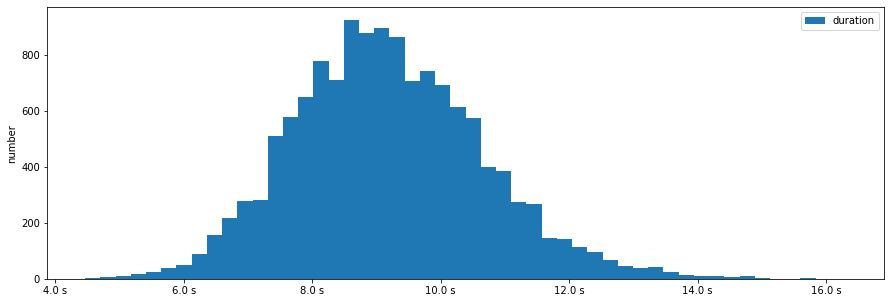

In [69]:
audio_duration.plot.hist(bins=50, figsize=(15, 5))
plt.ylabel('number')
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f s'))

最长的 5 条音频

In [70]:
audio_duration.head()

,duration
D32_980,16.3125
D32_964,15.6250
B4_276,15.6250
A36_178,15.5625
A7_183,15.2500


## 统计句子长度

读取音频对应的拼音

In [97]:
sentences = dict()

for file in tqdm(glob.glob('/content/data_thchs30/data/*.trn')):
  name = os.path.splitext(os.path.splitext(os.path.split(file)[1])[0])[0]
  with open(file) as f:
    words = next(f)
    pinyins = next(f).strip().split(' ')
  sentences[name] = pinyins

100%|██████████| 13388/13388 [00:10<00:00, 1263.52it/s]


计算字数

In [98]:
sentences_length = dict()
for k, v in sentences.items():
  sentences_length[k] = len(v)

sentences_length = pd.DataFrame.from_dict(sentences_length, orient='index', columns=['length'])
sentences_length = sentences_length.sort_values('length', ascending=False)

总字数

In [99]:
sentences_length.sum()

length    436604
dtype: int64

总体特征

In [100]:
sentences_length.describe()

,length
count,13388.000000
mean,32.611592
std,4.358704
min,19.000000
25%,30.000000
50%,33.000000
75%,35.000000
max,48.000000


长度分布

Text(0, 0.5, 'number')

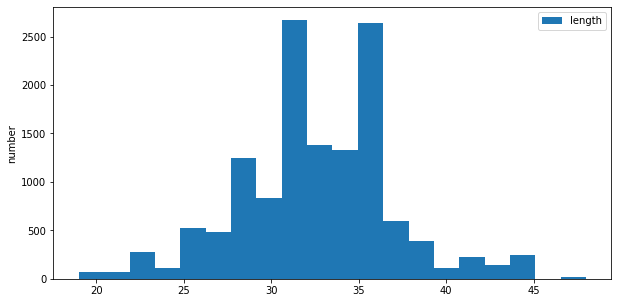

In [104]:
sentences_length.plot.hist(bins=20, figsize=(10, 5))
plt.ylabel('number')

最长的 5 条句子

In [101]:
sentences_length.head()

,length
D6_991,48
D21_991,48
D4_991,48
D32_991,48
D31_991,48


## 统计语速变化

In [118]:
speed_change = audio_duration['duration'] / sentences_length['length'] * 1000
speed_change = pd.DataFrame(speed_change, columns=['speed (ms)'])
speed_change = speed_change.sort_values('speed (ms)', ascending=False)

总体特征

In [119]:
speed_change.describe()

,speed (ms)
count,13388.000000
mean,283.115256
std,38.632655
min,171.351351
25%,255.357143
50%,279.513889
75%,306.555556
max,538.923077


语速分布

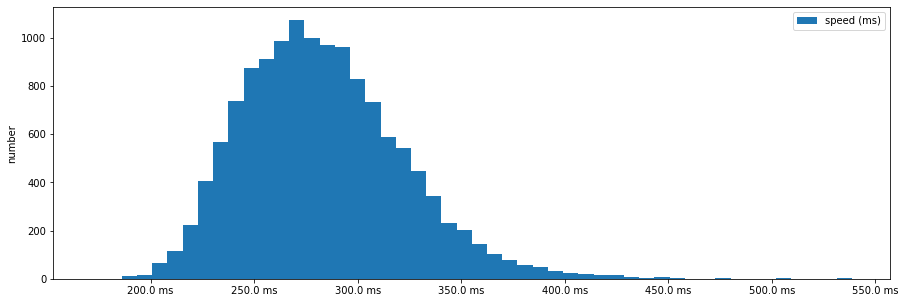

In [129]:
speed_change.plot.hist(bins=50, figsize=(15, 5))
plt.ylabel('number')
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f ms'))

语速最快的 5 条音频

In [124]:
speed_change.tail().iloc[::-1]

,speed (ms)
D12_832,171.351351
A11_217,186.857143
C32_707,187.500000
D13_915,188.296296
C32_692,189.102564


语速最慢的 5 条音频

In [122]:
speed_change.head()

,speed (ms)
C22_604,538.923077
C7_702,536.458333
C4_604,507.211538
C22_568,502.200000
C7_604,487.980769


## 统计发音覆盖范围

### 5 种声调的分布情况

In [132]:
pinyin_distribution = dict()

for pinyins in sentences.values():
  for i in pinyins:
    if i in pinyin_distribution:
      pinyin_distribution[i] +=1 
    else:
      pinyin_distribution[i] = 1

pinyin_distribution = pd.DataFrame.from_dict(pinyin_distribution, orient='index', columns=['number'])
pinyin_distribution = pinyin_distribution.sort_values('number', ascending=False)

总体特征

In [134]:
# 从结果来看，这个数据集并没有覆盖到所有的发音，一个使用4种声调的拼音表有1644种发音，而这里使用5种声调却只有1208种
pinyin_distribution.describe()

,number
count,1208.000000
mean,361.427152
std,628.961598
min,10.000000
25%,52.000000
50%,166.000000
75%,410.000000
max,12042.000000


发音分布

Text(0, 0.5, 'number')

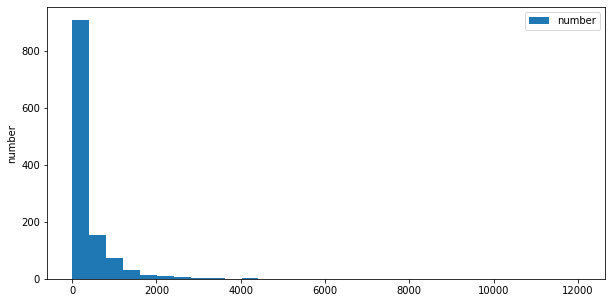

In [144]:
# 大部分的发音只出现了1次
pinyin_distribution.plot.hist(bins=30, figsize=(10, 5))
plt.ylabel('number')

出现次数前 5 的发音

In [138]:
pinyin_distribution.head()

,number
de5,12042
shi4,4835
shi2,4361
yi4,4290
you3,4087


### 去除声调后的分布情况

In [140]:
pinyin_distribution_without_intonation = dict()

for pinyins in sentences.values():
  for i in pinyins:
    i = i[:-1]
    if i in pinyin_distribution_without_intonation:
      pinyin_distribution_without_intonation[i] +=1 
    else:
      pinyin_distribution_without_intonation[i] = 1

pinyin_distribution_without_intonation = pd.DataFrame.from_dict(pinyin_distribution_without_intonation, orient='index', columns=['number'])
pinyin_distribution_without_intonation = pinyin_distribution_without_intonation.sort_values('number', ascending=False)

总体特征

In [141]:
# 从结果来看，即使不带声调也没有覆盖到所有的发音，不带声调的拼音表有411种发音，而这里却只有394种
pinyin_distribution_without_intonation.describe()

,number
count,394.000000
mean,1108.131980
std,1434.692945
min,14.000000
25%,323.500000
50%,655.500000
75%,1353.250000
max,12572.000000


发音分布

Text(0, 0.5, 'number')

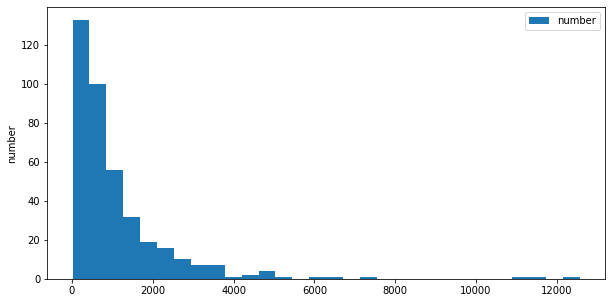

In [143]:
# 大部分的发音只出现了1次
pinyin_distribution_without_intonation.plot.hist(bins=30, figsize=(10, 5))
plt.ylabel('number')

出现次数前 5 的发音

In [145]:
pinyin_distribution_without_intonation.head()

,number
de,12572
yi,11639
shi,11049
you,7507
yu,6675
